<a href="https://colab.research.google.com/github/CuiChangIsLaJi/MissingDataTutorials/blob/main/complete_case_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
This tutorial will present you a toy model to investigate the biasedness of naive CC analysis and how the Inverse Probability Weighting(IPW) could help resolve this trouble.

As introduced in the lecture, Complete Case(CC) analysis is a simple, efficient but limited method to handle missing data, which is prone to severely biased estimation unless the MCAR assumption holds:

$$
p\left\{R\middle|X;\phi\right\} = p\left\{R\right\},\forall X,\phi
$$
where 
$$
R := \mathbf{1}_{\left\{X_{ij}\mathrm{obtained}\right\}}
$$ denotes the *response indicator matrix*. Here you would see how biasedness occurs when we simply reduce our condition to MAR case.

Well, the first and foremost step, import the libraries we need.

In [83]:
from matplotlib import pyplot as plt
import numpy as np
#Comment the following line if you are not running the code in IPython.
%matplotlib inline

# **Section 1: Dataset generation**
For simplicity, we consider a 2-variable MAR model $X_1,X_2 \sim \mathcal{N}(0,1)$ with part of $X_2$ missing. Specifically, the missingness probability of each $X_2$ entry is dependent on $X_1$:
$$
p\left\{R_{i2} = 0 \middle| X_1 \right\} = 
\begin{cases}
0.25, & X_1 > 0,\\
0.50, & X_1 \le0
\end{cases}
$$
while $p\left\{R_{i1} = 0\right\} = 0, \forall i$, as $X_1$ is supposed to be fully observed.

To make the situation real, consider our case a longitudinal investigation where $X_1$ stands for some sort of reward. The subject would certainly have a stronger tendency to quit if his payment is relatively low (the threshold is set to 0 for simplicity, but, of course, it is really a bad idea to draw money from subjects...so you might want to view 0 as the measurement of average payment level.)

In this section, let's see how we use random modules in NumPy to generate our toy dataset. We conduct a 500-epoch Bootstrap simulation with 100 data entries sampled one at a time, from a 10000-entry data pool obeying distribution $\mathcal{N}(0,1)$. The random seed is set to 1020 for nothing but reproducability (Wondering what this means?...Well, 1020 is my birthday, so...you know what to do then?).

In this simulation program, we need both the complete and damaged form of data, so we prefer maintaining the response matrix explicitly rather than directly setting part of the values to `NaN`. Also note that, the part of response indicator that we really care, namely $R_{(\cdot)2}$, contains only 1 column, and the information could then be stored using a 1-D array.

The trickiest part is to *simulate a random event on computer*. Typically we generate a (uniformly distributed, in this case) random number using NumPy function **random.random()** $\xi$, and compare it with our given probability $p$. We then set the event to happen if $\xi < p$ and not to happen otherwise.

In [84]:
np.random.seed(1020)
N_sample, p0, p1 = 10000, 0.25, 0.5

X1 = np.random.randn(N_sample)
X2 = np.random.randn(N_sample)

r = np.ones(N_sample)
for i in range(N_sample):
  xi = np.random.random()
  if ((X1[i] > 0) and (xi < p0)) or ((X1[i] <= 0) and (xi < p1)):
    r[i] = 0

#Check validity: the frequency of missing-data entries is close to the real probability 0.5 * 0.25 + 0.5 * 0.5 = 0.375
1 - r.sum() / N_sample

0.37360000000000004

#**Section 2: Bootstrap simulation**

We then run the 1000-epoch Bootstrap sampling and estimate the mean value of variable $X_2$. For an unbiased estimator, the mean value should be 0, according to the rule to generate data.

Here we pass 2 empty lists `avr_complete` and `avr_missing` and use the built-in Python operator `+=` to append an element to the list in-place. If you are familiar with the concept of **reference** in languages like C++, you should be comfortable with this sort of action.

In [85]:
def bootstrap_sampling(
    avr_complete, avr_missing,
    n_sample, n_epoch,
    data
    ):
  # "data" is a combination in form of [X2,r]
  for _ in range(n_epoch):
    sample = data[np.random.choice(
          np.arange(data.shape[0]), n_sample, replace = False  
        )]
    avr_complete += [sample[:,0].mean()]
    avr_missing += [sample[:,0][np.nonzero(sample[:,1])].mean()]

avr_complete, avr_missing = [], []
n_sample, n_epoch = 100, 500
data = np.stack([X2,r], axis = 1)
bootstrap_sampling(avr_complete, avr_missing, n_sample, n_epoch, data)

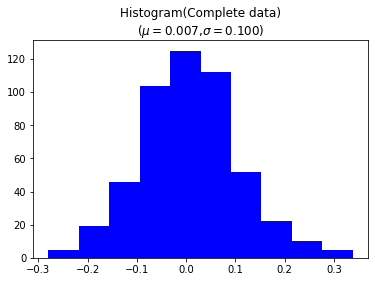

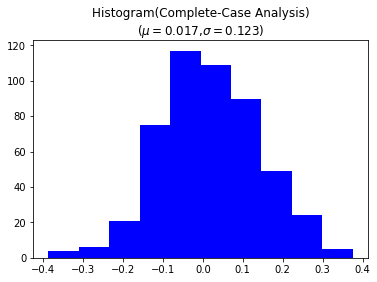

In [86]:
def plot_hist(avrs, label):
  n, bins, patches = plt.hist(avrs, 10, facecolor='b')
  plt.title("Histogram(" + label + ")\n($\mu = $" + str(avrs.mean())[:5] + ",$\sigma = $" + str(avrs.std())[:5] + ")")
  plt.show()

complete = np.array(avr_complete)
missing = np.array(avr_missing)
plot_hist(complete, "Complete data")
plot_hist(missing, "Complete-Case Analysis")

#**Section 3: Inverse Probability Weighting(IPW) algorithm**
As stated in the lecture, for univariate missingness patterns, one creates the unbiased estimator given below:
$$
\hat{\mu}_{r,m}^{\mathrm{IPWE}}
:=
\frac{1}{m}
\sum_{i=1}^m{\frac{Y_i 1_{\left\{R_j=r\right\}}}{
  \hat{p}_m\left\{R_i=r\middle|X_1^{(i)},X_2^{(i)}\right\}}
}
$$
where typically $\hat{p}_m\left\{R_i\middle|X_i\right\}$ should be modelled and inferenced using a variety of schemes.

But, fortunately in our toy model, this probability could be exactly determined(take $r=1$):
$$
\hat{p}_m\left\{R_i=1\middle|X_1^{(i)},X_2^{(i)}\right\}
=
\hat{p}_m\left\{R_i=1\middle|X_1^{(i)}\right\}
=
1 - p(X_1^{(i)})
$$
where $p(\cdot)$ is given in Section 1.

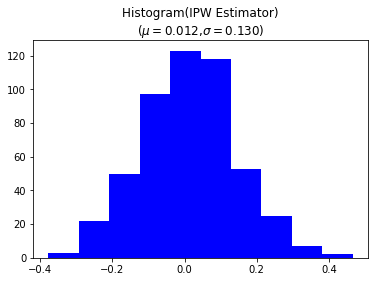

In [87]:
def bootstrap_ipw_sampling(
    avr,
    n_sample, n_epoch,
    data
    ):
  # "data" is a combination in form of [X2,weights]
  for _ in range(n_epoch):
    sample = data[np.random.choice(
          np.arange(data.shape[0]), n_sample, replace = False  
        )]
    avr += [
        (sample[:,0] * sample[:,1]).mean()
    ]

ipws = []
weights = [1/(1-p0) if x > 0 else 1/(1-p1) for x in X1]
for idx in np.where(r == 0)[0]:
  weights[idx] = 0
data = np.stack([X2,weights], axis = 1)
bootstrap_ipw_sampling(ipws, n_sample, n_epoch, data)
plot_hist(np.array(ipws), "IPW Estimator")

Now you have percepted a deeper understanding of how IPW works. But note that due to numerical unstability, in some runs the IPW method yields worse results than CC, which definitely astonished me at midnight... 😳

Have a good day!